# Intro

## Premise
The issue is always the same: is everything we are doing correct?  
The fact that there is a non trivial superposition between Witten's review and all our documents is suspect...

## Standard modules

In [1]:
import os, sys
import pathlib
import requests

In [2]:
import numpy as np

In [3]:
from tqdm.auto import tqdm, trange

In [4]:
from sentence_transformers import util

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

In [69]:
from sklearn.preprocessing import Normalizer
import umap

In [7]:
import seaborn

In [8]:
import pymannkendall as mk

## Personal modules

In [9]:
from toolbox.updater import time_is_now

In [10]:
from file2text import file2text

In [11]:
from first_rough_cleaning import first_text_cleaner

In [12]:
from file_handler import *

In [13]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Folders

In [14]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [15]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [140]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/abtt5_vectors/'

In [142]:
ABTT1_VECTOR_FOLDER='./NewProcessedData/abtt1_vectors/'

In [17]:
WIKI_FOLDER='./NewProcessedData/wikipedia/vectors/'

## Reports' vectors

In [18]:
vecfiles=os.listdir(VECTOR_FOLDER)

In [19]:
vecfiles.sort()

In [20]:
# files from 2024 are un reliable, 
# as they probably refer to a different accounting year,
# due to differences with other countries
len(vecfiles)

575

In [21]:
vecfiles=[vecfile for vecfile in vecfiles if not vecfile.startswith('2024')]

In [22]:
len(vecfiles)

573

## Witten's vector

In [23]:
wittenvecfile=[file for file in os.listdir(BENCHMARK_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [24]:
wittenvec=np.genfromtxt(BENCHMARK_FOLDER+wittenvecfile)

# Mean vector

In [25]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    if i==0:
        mean_vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    else:
        mean_vec+=np.genfromtxt(VECTOR_FOLDER+vecfile)
mean_vec/=len(vecfiles)

  0%|          | 0/573 [00:00<?, ?it/s]

# Witten is quite close to be mean

 Witten is quite close to be mean

In [26]:
util.cos_sim(wittenvec, mean_vec)

tensor([[0.8199]], dtype=torch.float64)

In [119]:
pure_cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    cos_sim=float(util.cos_sim(wittenvec, vec))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pure_cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

In [27]:
cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    cos_sim=float(util.cos_sim(wittenvec, vec-mean_vec))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

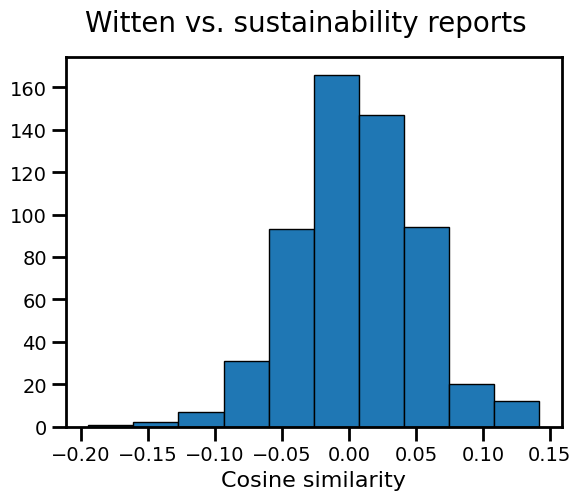

In [28]:
plt.hist(cos_sims, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports', fontsize=20)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

That's much better. 

# PCA

The dimension fo the embedding is the same for all vectors:

In [29]:
len(wittenvec)

768

In [161]:
vecs=np.zeros((len(vecfiles), len(wittenvec)))

In [162]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    vecs[i]=vec

  0%|          | 0/573 [00:00<?, ?it/s]

## Which percentage?

In [163]:
pca = PCA()
new_vecs=pca.fit_transform(vecs)

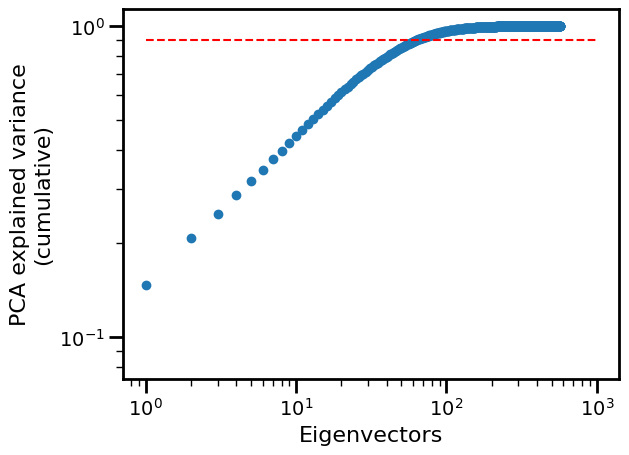

In [167]:
plt.scatter(np.arange(len(vecfiles)), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(0.90, 1, 1000, ls='--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PCA explained variance\n(cumulative)', fontsize=16)
plt.xlabel('Eigenvectors', fontsize=16)
plt.savefig('./NewPlots/postprocessing_pca.pdf', bbox_inches='tight')
plt.show()

In [34]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.90)[0][-1]

63

In [35]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.95)[0][-1]

87

In [36]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.99)[0][-1]

160

## Dimensional reduction

In [37]:
pca = PCA(n_components=63)
new_vecs=pca.fit_transform(vecs)

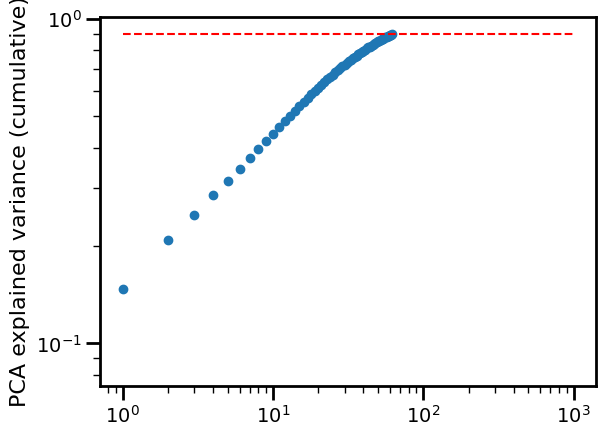

In [38]:
plt.scatter(np.arange(63), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(0.90, 1, 1000, ls='--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PCA explained variance (cumulative)', fontsize=16)
plt.show()

## Check with Witten

In [39]:
wittenvec.T

array([-3.02811189e-02, -3.81932141e-02,  5.04839207e-02, -8.00098124e-03,
       -3.53469865e-02, -3.23630692e-03, -6.81020060e-03, -2.89417768e-02,
        5.92756829e-02,  8.08559115e-03, -1.55386966e-02, -9.66650055e-03,
       -3.56608460e-02, -6.64788847e-03, -4.35948768e-02,  7.00658821e-02,
       -1.15720409e-02,  6.07534971e-03,  6.03255241e-03, -9.20716491e-03,
       -1.40867959e-02, -3.93993677e-02, -3.48379897e-02, -9.90491321e-03,
        2.00452551e-02, -1.42847605e-03,  5.88203656e-02,  2.48458379e-02,
        4.49237034e-02,  3.21563627e-02,  2.96030887e-03, -2.53623230e-02,
       -4.41500462e-02,  1.02410977e-02,  2.29212367e-04, -6.59512065e-02,
       -1.54529956e-02, -1.65040052e-03,  7.72846153e-02,  6.11668911e-02,
       -2.46362986e-02,  5.33290305e-03,  1.44023294e-02,  6.18857648e-02,
       -5.30239550e-02, -9.63267495e-03, -1.90574004e-02,  1.46386031e-02,
       -2.03105476e-02, -4.04475940e-02, -2.31404802e-02, -3.59528446e-02,
        2.79525956e-03, -

In [40]:
new_wittenvec = pca.transform([wittenvec])

In [41]:
pca_cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(new_wittenvec, new_vecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

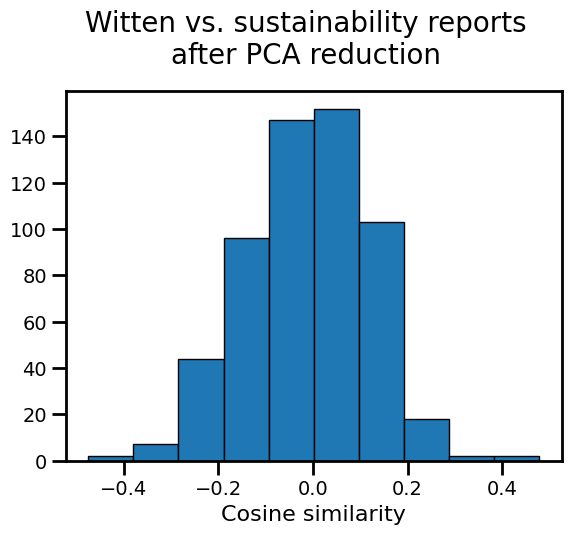

In [42]:
plt.hist(pca_cos_sims, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports\nafter PCA reduction', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

# Post-processing

In [29]:
allvecs=np.zeros((len(vecfiles), len(wittenvec)))

In [30]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    allvecs[i]=vec

  0%|          | 0/573 [00:00<?, ?it/s]

## All-but-the-top, n_comp=5

The sense of the PCA in our context is that there is still a residual bulk of spurious signal carried by the 1st component of the PCA that is uninformative. Therefore, we remove it, once we remove the effect of the mean vector.

In [31]:
no_mean_vecs=allvecs-mean_vec

In [139]:
k = 5
pca = PCA(n_components=k)
pca.fit(no_mean_vecs)
U = pca.components_          # matrice k × d

# Proiezione su subspazio delle prime k PC
no_mean_vecs_proj = no_mean_vecs.dot(U.T).dot(U)   # (n, d)

# Rimozione delle k componenti
no_mean_vecs_debiased = no_mean_vecs - no_mean_vecs_proj

### Check with Witten

In [33]:
new_wittenvec = wittenvec - mean_vec
new_wittenvec-=new_wittenvec.dot(U.T).dot(U)

In [34]:
pca_cos_sims_w=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(new_wittenvec, no_mean_vecs_debiased[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims_w[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

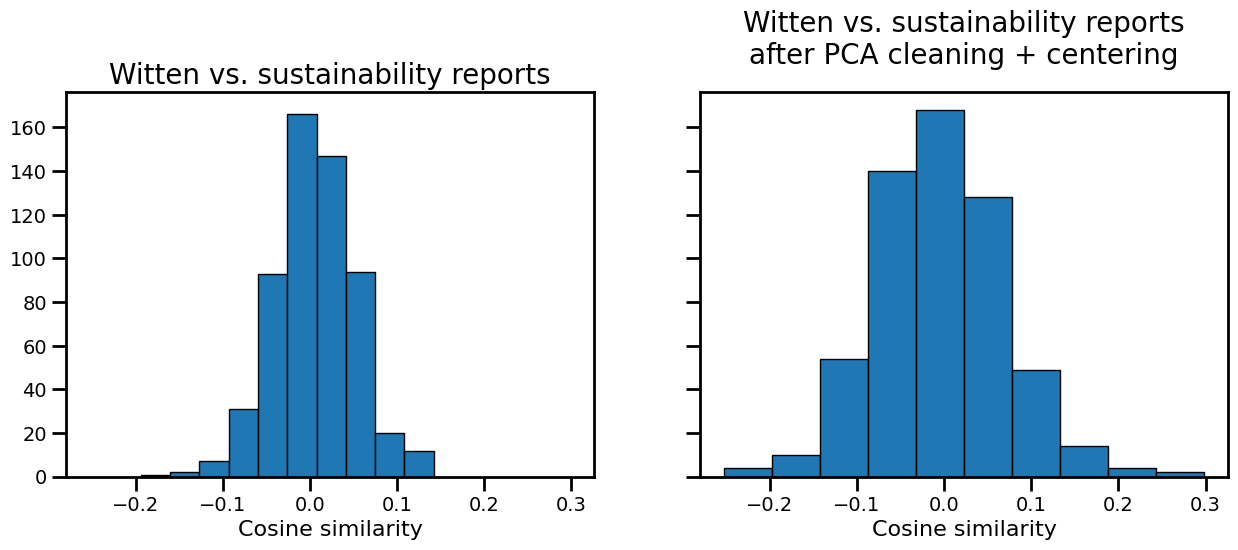

In [35]:
fig, axs=plt.subplots(1,2,sharex=True, sharey=True, figsize=(15, 5))

axs[0].hist(cos_sims, edgecolor='black')
axs[0].set_title('Witten vs. sustainability reports', fontsize=20)
axs[0].set_xlabel('Cosine similarity', fontsize=16)


axs[1].hist(pca_cos_sims_w, edgecolor='black')
axs[1].set_title('Witten vs. sustainability reports\nafter PCA cleaning + centering', fontsize=20, y=1.05)
axs[1].set_xlabel('Cosine similarity', fontsize=16)
plt.show()

In [36]:
np.mean(cos_sims), np.std(cos_sims)

(0.005177349204742545, 0.04661277849958448)

In [37]:
np.mean(pca_cos_sims_w), np.std(pca_cos_sims_w)

(-0.004647873713889934, 0.07455877477613415)

## All-but-the-top, n_comp=1

The sense of the PCA in our context is that there is still a residual bulk of spurious signal carried by the 1st component of the PCA that is uninformative. Therefore, we remove it, once we remove the effect of the mean vector.

In [130]:
k = 1
pca = PCA(n_components=k)
pca.fit(no_mean_vecs)
U = pca.components_          # matrice k × d

# Proiezione su subspazio delle prime k PC
no_mean_vecs_proj_1 = no_mean_vecs.dot(U.T).dot(U)   # (n, d)

# Rimozione delle k componenti
no_mean_vecs_debiased_1 = no_mean_vecs - no_mean_vecs_proj_1

### Check with Witten

In [131]:
new_wittenvec_1 = wittenvec - mean_vec
new_wittenvec_1-=new_wittenvec_1.dot(U.T).dot(U)

In [132]:
pca_cos_sims_w_1=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(new_wittenvec_1, no_mean_vecs_debiased_1[i]))
    pca_cos_sims_w_1[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

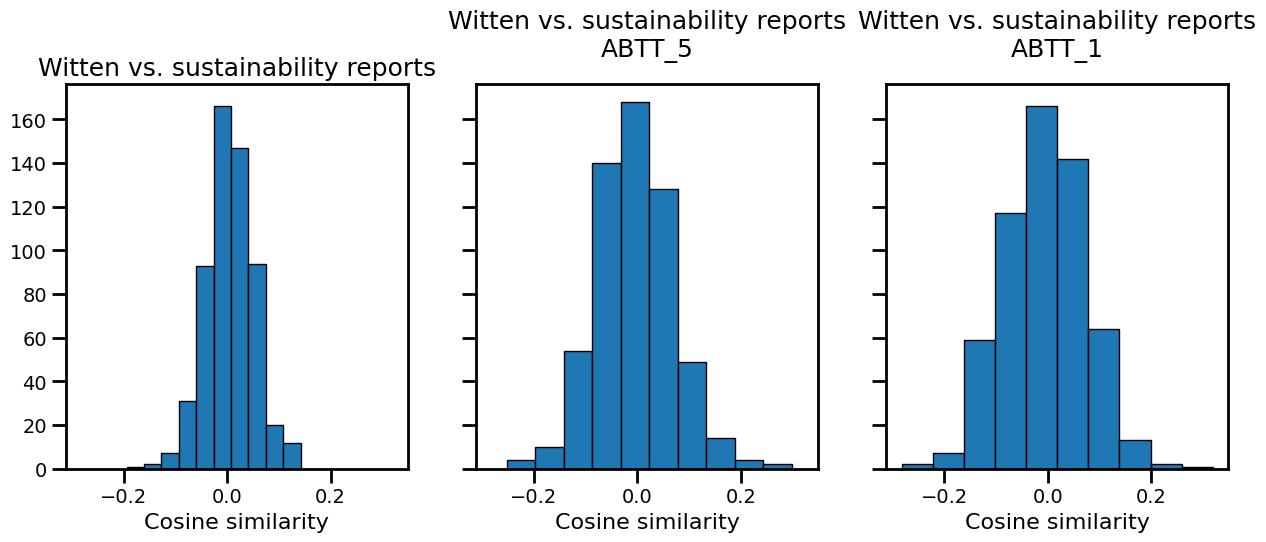

In [138]:
fig, axs=plt.subplots(1,3,sharex=True, sharey=True, figsize=(15, 5))

axs[0].hist(cos_sims, edgecolor='black')
axs[0].set_title('Witten vs. sustainability reports', fontsize=18)
axs[0].set_xlabel('Cosine similarity', fontsize=16)


axs[1].hist(pca_cos_sims_w, edgecolor='black')
axs[1].set_title('Witten vs. sustainability reports\nABTT_5', fontsize=18, y=1.05)
axs[1].set_xlabel('Cosine similarity', fontsize=16)

axs[2].hist(pca_cos_sims_w_1, edgecolor='black')
axs[2].set_title('Witten vs. sustainability reports\nABTT_1', fontsize=18, y=1.05)
axs[2].set_xlabel('Cosine similarity', fontsize=16)

plt.show()

In [134]:
np.mean(cos_sims), np.std(cos_sims)

(0.005177349204742545, 0.04661277849958448)

In [135]:
np.mean(pca_cos_sims_w), np.std(pca_cos_sims_w)

(-0.004647873713889934, 0.07455877477613415)

In [136]:
np.mean(pca_cos_sims_w_1), np.std(pca_cos_sims_w_1)

(-0.005353071860960581, 0.0788278205827092)

## RobustScaler

It should rescale more efficiently, proper considering outliers.

In [38]:
rs = RobustScaler()
rs.fit(allvecs)

rs_allvecs=rs.transform(allvecs)

### Check with Witten

In [39]:
rs_wittenvec=rs.transform([wittenvec])

In [40]:
rs_cos_sims_w=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(rs_wittenvec, rs_allvecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    rs_cos_sims_w[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

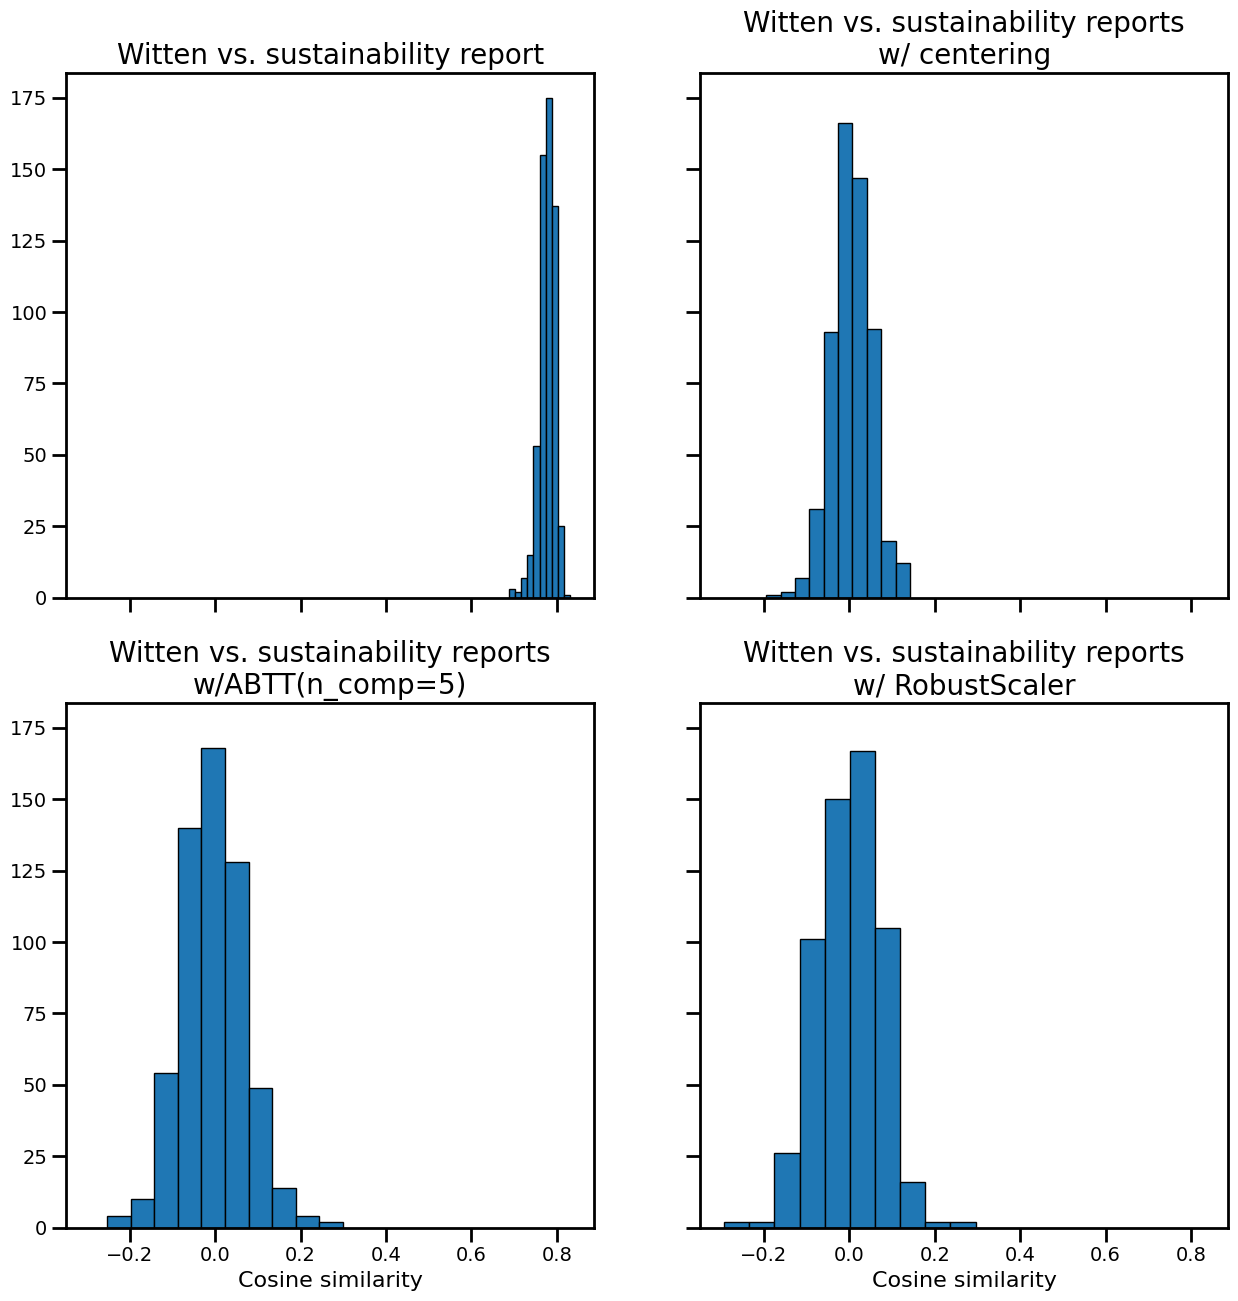

In [129]:
fig, axs=plt.subplots(2,2,sharex=True, sharey=True, figsize=(15, 15))

axs[0, 0].hist(pure_cos_sims, edgecolor='black')
axs[0, 0].set_title('Witten vs. sustainability report', fontsize=20)
#axs[0, 0].set_xlabel('Cosine similarity', fontsize=16)

axs[0,1].hist(cos_sims, edgecolor='black')
axs[0,1].set_title('Witten vs. sustainability reports\nw/ centering', fontsize=20)
#axs[0,1].set_xlabel('Cosine similarity', fontsize=16)

axs[1,0].hist(pca_cos_sims_w, edgecolor='black')
axs[1,0].set_title('Witten vs. sustainability reports\nw/ABTT(n_comp=5)', fontsize=20)
axs[1,0].set_xlabel('Cosine similarity', fontsize=16)

axs[1,1].hist(rs_cos_sims_w, edgecolor='black')
axs[1,1].set_title('Witten vs. sustainability reports\nw/ RobustScaler', fontsize=20)
axs[1,1].set_xlabel('Cosine similarity', fontsize=16)
plt.savefig('./NewPlots/postprocessing.pdf', bbox_inches='tight')
plt.show()

In [42]:
np.mean(cos_sims), np.std(cos_sims)

(0.005177349204742545, 0.04661277849958448)

In [43]:
np.mean(pca_cos_sims_w), np.std(pca_cos_sims_w)

(-0.004647873713889934, 0.07455877477613415)

In [44]:
np.mean(rs_cos_sims_w), np.std(rs_cos_sims_w)

(0.0007621024673115121, 0.07322976536378889)

Are they so different?

In [45]:
from scipy.stats import kstest

In [46]:
kstest(pca_cos_sims_w, rs_cos_sims_w)

KstestResult(statistic=0.07329842931937172, pvalue=0.09203818484298212, statistic_location=0.013452324571173993, statistic_sign=1)

Well, not enough to be statistically different with $\alpha=0.1$, but quite close. 

## Quantile Uniform 

The best methods according to those guys...

In [47]:
qt = QuantileTransformer(n_quantiles=200)
qt.fit(allvecs)

qt_allvecs=qt.transform(allvecs)

### Check with Witten

In [48]:
qt_wittenvec=qt.transform([wittenvec])

In [49]:
qt_cos_sims_w=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(qt_wittenvec, qt_allvecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    qt_cos_sims_w[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

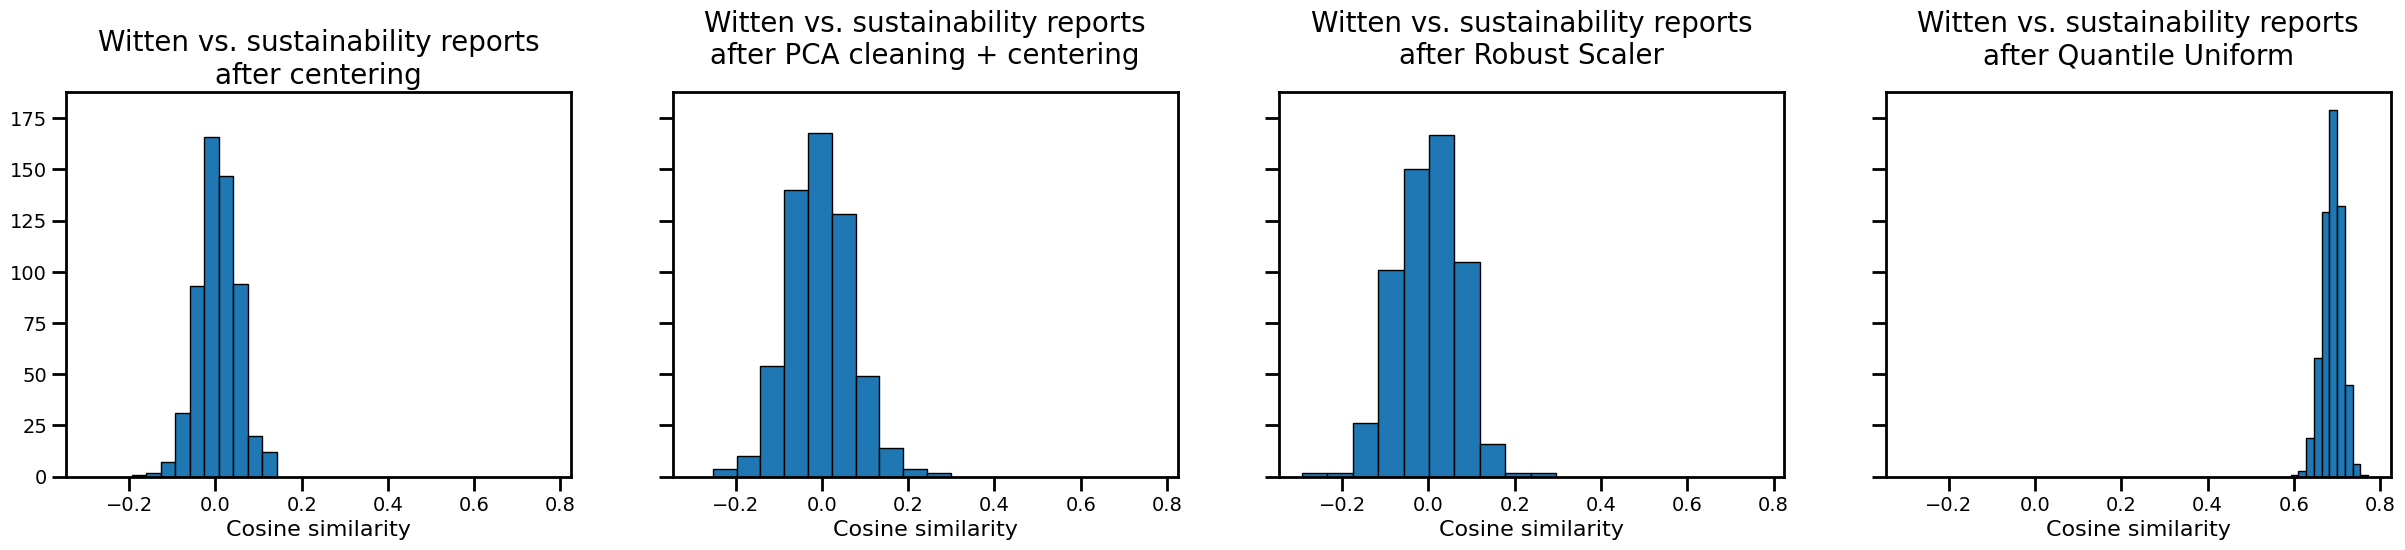

In [50]:
fig, axs=plt.subplots(1,4,sharex=True, sharey=True, figsize=(30, 5))

axs[0].hist(cos_sims, edgecolor='black')
axs[0].set_title('Witten vs. sustainability reports\nafter centering', fontsize=20)
axs[0].set_xlabel('Cosine similarity', fontsize=16)

axs[1].hist(pca_cos_sims_w, edgecolor='black')
axs[1].set_title('Witten vs. sustainability reports\nafter PCA cleaning + centering', fontsize=20, y=1.05)
axs[1].set_xlabel('Cosine similarity', fontsize=16)

axs[2].hist(rs_cos_sims_w, edgecolor='black')
axs[2].set_title('Witten vs. sustainability reports\nafter Robust Scaler', fontsize=20, y=1.05)
axs[2].set_xlabel('Cosine similarity', fontsize=16)

axs[3].hist(qt_cos_sims_w, edgecolor='black')
axs[3].set_title('Witten vs. sustainability reports\nafter Quantile Uniform', fontsize=20, y=1.05)
axs[3].set_xlabel('Cosine similarity', fontsize=16)

plt.show()

In [51]:
np.mean(cos_sims), np.std(cos_sims)

(0.005177349204742545, 0.04661277849958448)

In [52]:
np.mean(pca_cos_sims_w), np.std(pca_cos_sims_w)

(-0.004647873713889934, 0.07455877477613415)

In [53]:
np.mean(rs_cos_sims_w), np.std(rs_cos_sims_w)

(0.0007621024673115121, 0.07322976536378889)

In [54]:
np.mean(qt_cos_sims_w), np.std(qt_cos_sims_w)

(0.6891202298029715, 0.02288297583097197)

## UMAP
Deepseek's suggestion

In [74]:
# Step 1: Normalizzazione L2 nello spazio originale
normalizer = Normalizer(norm='l2')
normalized_allvecs = normalizer.fit_transform(allvecs)
normalized_wittenvec = normalizer.fit_transform([wittenvec])
normalized_wittenvec=normalized_wittenvec[0]

In [75]:
reducer = umap.UMAP(
    n_components=30,          # Mantenere più dimensioni
    n_neighbors=5,            # Valorizzare strutture locali
    min_dist=0.8,             # Aumentare separazione cluster
    metric='cosine',          # Coerente con normalizzazione
    output_metric='cosine',   # Mantenere metrica angolare
    random_state=42
)

In [76]:
 reducer.fit(normalized_allvecs)

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.8, n_components=30, n_jobs=1, n_neighbors=5, output_metric='cosine', random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [77]:
umap_allvecs=reducer.transform(normalized_allvecs)

### Check with Witten

In [88]:
umap_wittenvec=reducer.transform([normalized_wittenvec])
umap_wittenvec=umap_wittenvec[0]

In [89]:
umap_cos_sims_w=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(umap_wittenvec, umap_allvecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    umap_cos_sims_w[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

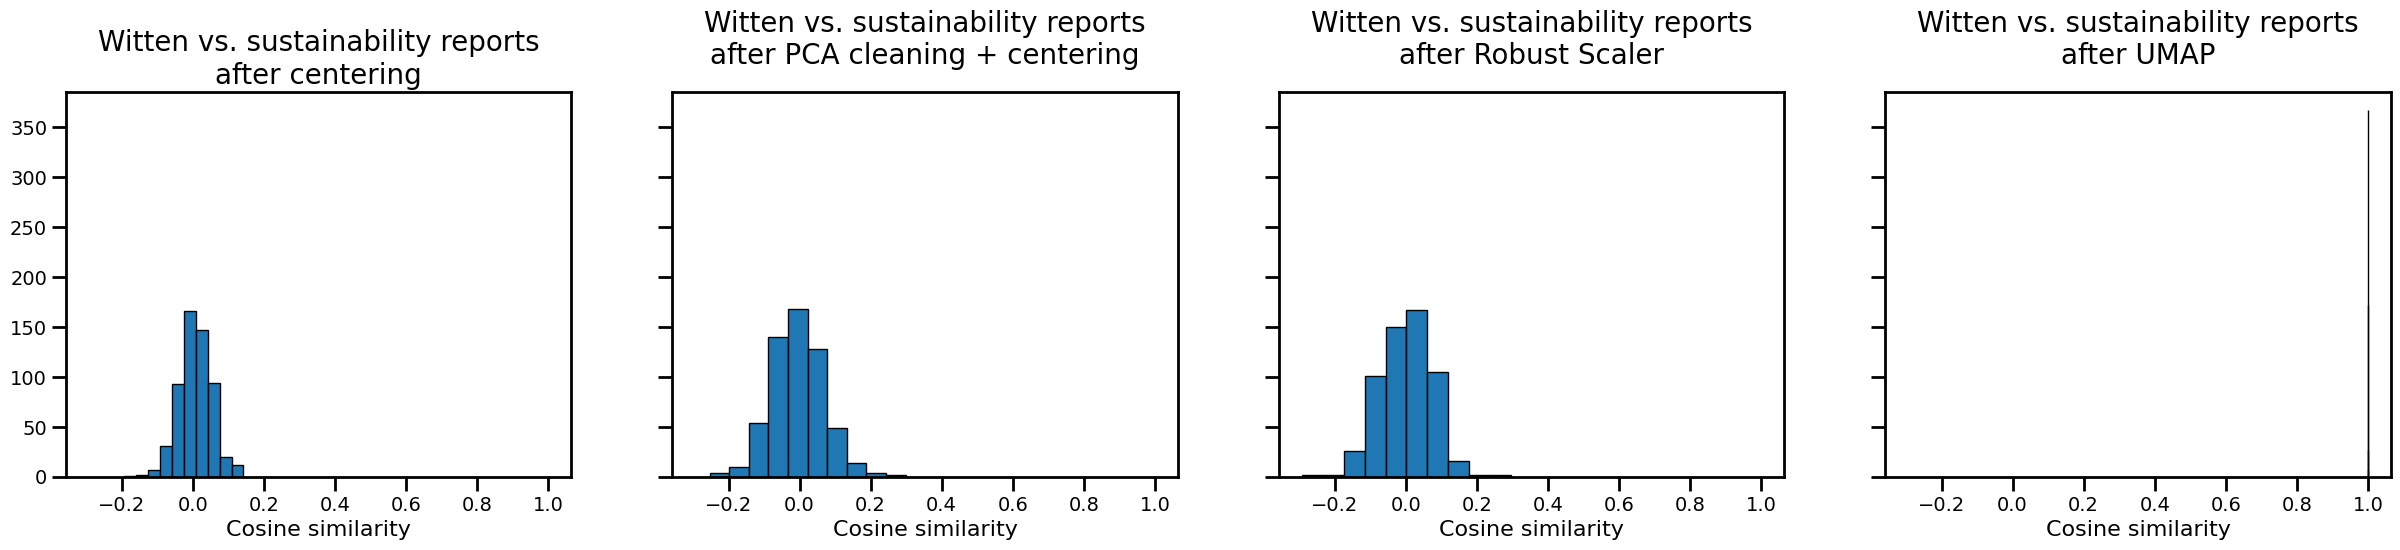

In [90]:
fig, axs=plt.subplots(1,4,sharex=True, sharey=True, figsize=(30, 5))

axs[0].hist(cos_sims, edgecolor='black')
axs[0].set_title('Witten vs. sustainability reports\nafter centering', fontsize=20)
axs[0].set_xlabel('Cosine similarity', fontsize=16)

axs[1].hist(pca_cos_sims_w, edgecolor='black')
axs[1].set_title('Witten vs. sustainability reports\nafter PCA cleaning + centering', fontsize=20, y=1.05)
axs[1].set_xlabel('Cosine similarity', fontsize=16)

axs[2].hist(rs_cos_sims_w, edgecolor='black')
axs[2].set_title('Witten vs. sustainability reports\nafter Robust Scaler', fontsize=20, y=1.05)
axs[2].set_xlabel('Cosine similarity', fontsize=16)

axs[3].hist(umap_cos_sims_w, edgecolor='black')
axs[3].set_title('Witten vs. sustainability reports\nafter UMAP', fontsize=20, y=1.05)
axs[3].set_xlabel('Cosine similarity', fontsize=16)

plt.show()

In [91]:
np.mean(cos_sims), np.std(cos_sims)

(0.005177349204742545, 0.04661277849958448)

In [92]:
np.mean(pca_cos_sims_w), np.std(pca_cos_sims_w)

(-0.004647873713889934, 0.07455877477613415)

In [93]:
np.mean(rs_cos_sims_w), np.std(rs_cos_sims_w)

(0.0007621024673115121, 0.07322976536378889)

In [94]:
np.mean(umap_cos_sims_w), np.std(umap_cos_sims_w)

(1.0000000868584265, 6.54170625999626e-08)

## Check the internal similarity

In [95]:
nmv_cs=[]
abtt_cs=[]
rs_cs=[]
umap_cs=[]
for i in trange(len(no_mean_vecs)):
    for j in range(i+1, len(no_mean_vecs)):
        nmv_cs.append(float(util.cos_sim(no_mean_vecs[i], no_mean_vecs[j])))
        abtt_cs.append(float(util.cos_sim(no_mean_vecs_debiased[i], no_mean_vecs_debiased[j])))
        rs_cs.append(float(util.cos_sim(rs_allvecs[i], rs_allvecs[j])))
        umap_cs.append(float(util.cos_sim(umap_allvecs[i], umap_allvecs[j])))
            

  0%|          | 0/573 [00:00<?, ?it/s]

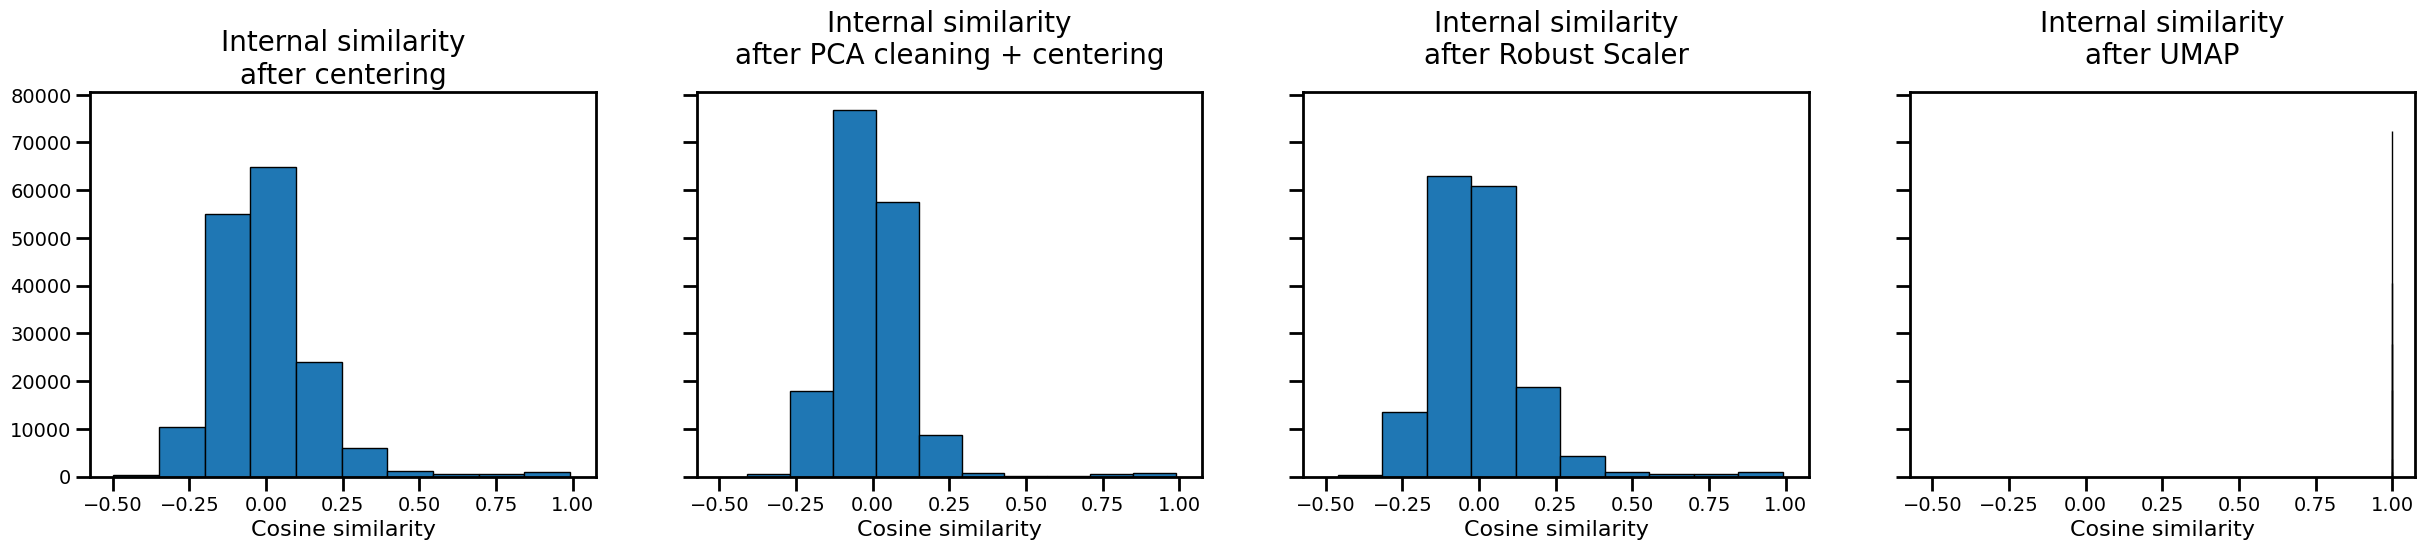

In [96]:
fig, axs=plt.subplots(1,4,sharex=True, sharey=True, figsize=(30, 5))

axs[0].hist(nmv_cs, edgecolor='black')
axs[0].set_title('Internal similarity\nafter centering', fontsize=20)
axs[0].set_xlabel('Cosine similarity', fontsize=16)

axs[1].hist(abtt_cs, edgecolor='black')
axs[1].set_title('Internal similarity\nafter PCA cleaning + centering', fontsize=20, y=1.05)
axs[1].set_xlabel('Cosine similarity', fontsize=16)

axs[2].hist(rs_cs, edgecolor='black')
axs[2].set_title('Internal similarity\nafter Robust Scaler', fontsize=20, y=1.05)
axs[2].set_xlabel('Cosine similarity', fontsize=16)

axs[3].hist(umap_cs, edgecolor='black')
axs[3].set_title('Internal similarity\nafter UMAP', fontsize=20, y=1.05)
axs[3].set_xlabel('Cosine similarity', fontsize=16)

plt.show()

In [97]:
np.mean(nmv_cs), np.std(nmv_cs)

(-0.0013297543442454167, 0.16346839178999395)

In [98]:
np.mean(abtt_cs), np.std(abtt_cs)

(-0.0011572043002820221, 0.13018291837979643)

In [99]:
np.mean(rs_cs), np.std(rs_cs)

(0.0015516712885934964, 0.1558217895637591)

In [100]:
np.mean(umap_cs), np.std(umap_cs)

(0.9999999889460186, 7.697513123885326e-08)

All but QT and UMAP are essentially equivalent.

## Save transformed vectors w/ ABTT5

### Function

In [101]:
def abtt(vec, mean_vec, U):
    no_mean_vec=vec-mean_vec
    # Proiezione su subspazio delle prime k PC
    no_mean_vec_proj = no_mean_vec.dot(U.T).dot(U)   # (n, d)

    # Rimozione delle k componenti
    return no_mean_vec - no_mean_vec_proj

### Reports

In [102]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+vecfile, no_mean_vecs_debiased[i])

  0%|          | 0/573 [00:00<?, ?it/s]

### New Benchmarks

In [103]:
benchmark_files=[file for file in os.listdir(BENCHMARK_FOLDER) if file.endswith('.txt') and (file.startswith('Goal') or file.startswith('Witten'))]
benchmark_files.sort()
for file in tqdm(benchmark_files):
    bench_vec=np.genfromtxt(BENCHMARK_FOLDER+file)
    new_bench_vec=abtt(bench_vec, mean_vec, U)
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+file, new_bench_vec)

  0%|          | 0/19 [00:00<?, ?it/s]

In [104]:
for goalvecfile in benchmark_files:
    if goalvecfile.startswith('Goal'):
        num=goalvecfile.split('_')[0].split('-')[1]
        if len(num)==1:
            new_name='Goal-'+num.zfill(2)+'-Fast-Facts.txt'
            os.rename(PCA_CENTR_VECTOR_FOLDER+goalvecfile, PCA_CENTR_VECTOR_FOLDER+new_name)

In [105]:
goalfiles=[file for file in os.listdir(PCA_CENTR_VECTOR_FOLDER) if file.endswith('.txt') and file.startswith('Goal')]
goalfiles.sort()
goalfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

### Check with SDGs

#### Goals' vectors

In [106]:
goalvecfiles=[file for file in os.listdir(PCA_CENTR_VECTOR_FOLDER) if file.startswith('Goal') and file.endswith('.txt')]

In [107]:
goalvecfiles.sort()

In [108]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [109]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

#### Cosine similarity

In [110]:
pca_cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(goalvecs[-1], no_mean_vecs_debiased[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

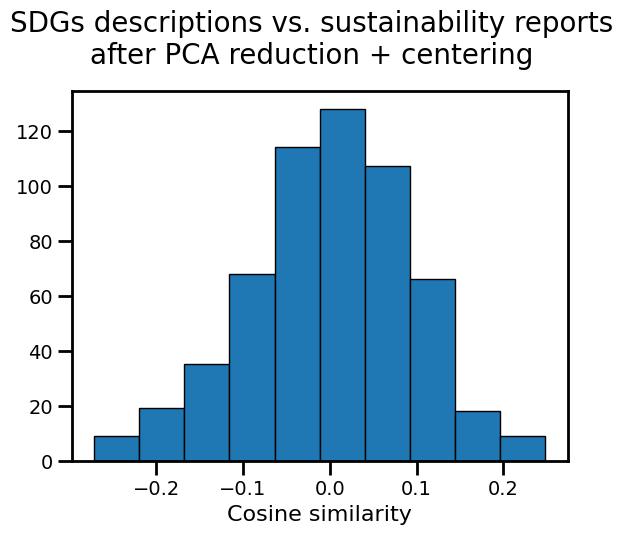

In [111]:
plt.hist(pca_cos_sims, edgecolor='black')
plt.suptitle('SDGs descriptions vs. sustainability reports\nafter PCA reduction + centering', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

In [112]:
np.mean(pca_cos_sims), np.std(pca_cos_sims)

(0.0018703185205884044, 0.09357543006730687)

In [113]:
pca_cos_sims=[]
for i in trange(len(goalvecs)):
    for j in range(i+1, len(goalvecs)):
        cos_sim=float(util.cos_sim(goalvecs[i], goalvecs[j]))
        pca_cos_sims.append(cos_sim)

  0%|          | 0/18 [00:00<?, ?it/s]

In [114]:
pca_cos_sims

[0.6532858317177546,
 0.5283404005746022,
 0.550223077041782,
 0.4290177524663247,
 0.495244325477645,
 0.37414380088948307,
 0.5212042981767543,
 0.4157446191893887,
 0.6693020872331104,
 0.4509953428947178,
 0.26401753130209393,
 0.49982639186423683,
 0.3558651499025637,
 0.45886994826079736,
 0.4923898834920979,
 0.4465015085847993,
 0.7329946487292878,
 0.5086426115522211,
 0.5273387029723189,
 0.4027923487914574,
 0.47656600793851955,
 0.4611060125351425,
 0.466723687744066,
 0.3912216411250902,
 0.5827973177462534,
 0.48190221318676657,
 0.4018153881024489,
 0.4662832555623385,
 0.3745142567804899,
 0.45260773835520435,
 0.5087048780706849,
 0.4285424994572231,
 0.71003090627432,
 0.5219408005843398,
 0.5204051366692478,
 0.5895143576706758,
 0.4313473796387618,
 0.4874332049432538,
 0.3764103648902498,
 0.5821687088027911,
 0.46924082445803056,
 0.2120072551094181,
 0.3960011462028743,
 0.2749557245209251,
 0.3930790006494992,
 0.5143056547926124,
 0.41659839441215474,
 0.698135

### Wikipedia benchmark

In [115]:
wikipedia_files=[file for file in os.listdir(WIKI_FOLDER) if file.endswith('.txt') and file.startswith('wikipedia')]
for file in tqdm(wikipedia_files):
    bench_vec=np.genfromtxt(WIKI_FOLDER+file)
    new_bench_vec=abtt(bench_vec, mean_vec, U)
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+file, new_bench_vec)

  0%|          | 0/4001 [00:00<?, ?it/s]

In [116]:
len(new_bench_vec)

768

## Save transformed vectors w/ ABTT1

In [141]:
k = 1
pca = PCA(n_components=k)
pca.fit(no_mean_vecs)
U = pca.components_          # matrice k × d

# Proiezione su subspazio delle prime k PC
no_mean_vecs_proj_1 = no_mean_vecs.dot(U.T).dot(U)   # (n, d)

# Rimozione delle k componenti
no_mean_vecs_debiased_1 = no_mean_vecs - no_mean_vecs_proj_1

### Reports

In [144]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    np.savetxt(ABTT1_VECTOR_FOLDER+vecfile, no_mean_vecs_debiased_1[i])

  0%|          | 0/573 [00:00<?, ?it/s]

### New Benchmarks

In [145]:
benchmark_files=[file for file in os.listdir(BENCHMARK_FOLDER) if file.endswith('.txt') and (file.startswith('Goal') or file.startswith('Witten'))]
benchmark_files.sort()
for file in tqdm(benchmark_files):
    bench_vec=np.genfromtxt(BENCHMARK_FOLDER+file)
    new_bench_vec=abtt(bench_vec, mean_vec, U)
    np.savetxt(ABTT1_VECTOR_FOLDER+file, new_bench_vec)

  0%|          | 0/19 [00:00<?, ?it/s]

In [146]:
for goalvecfile in benchmark_files:
    if goalvecfile.startswith('Goal'):
        num=goalvecfile.split('_')[0].split('-')[1]
        if len(num)==1:
            new_name='Goal-'+num.zfill(2)+'-Fast-Facts.txt'
            os.rename(ABTT1_VECTOR_FOLDER+goalvecfile, ABTT1_VECTOR_FOLDER+new_name)

In [147]:
goalfiles=[file for file in os.listdir(ABTT1_VECTOR_FOLDER) if file.endswith('.txt') and file.startswith('Goal')]
goalfiles.sort()
goalfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

## Check with SDGs

### Goals' vectors

In [148]:
goalvecfiles=[file for file in os.listdir(ABTT1_VECTOR_FOLDER) if file.startswith('Goal') and file.endswith('.txt')]

In [149]:
goalvecfiles.sort()

In [150]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [151]:
goalvecs=[np.genfromtxt(ABTT1_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Cosine similarity

In [152]:
pca_cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(goalvecs[-1], no_mean_vecs_debiased[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

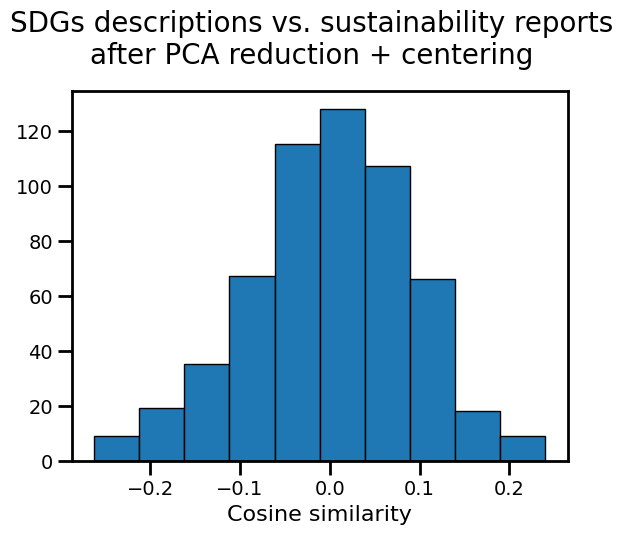

In [153]:
plt.hist(pca_cos_sims, edgecolor='black')
plt.suptitle('SDGs descriptions vs. sustainability reports\nafter PCA reduction + centering', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

In [154]:
np.mean(pca_cos_sims), np.std(pca_cos_sims)

(0.0018071073694717638, 0.09051125483656898)

In [155]:
pca_cos_sims=[]
for i in trange(len(goalvecs)):
    for j in range(i+1, len(goalvecs)):
        cos_sim=float(util.cos_sim(goalvecs[i], goalvecs[j]))
        pca_cos_sims.append(cos_sim)

  0%|          | 0/18 [00:00<?, ?it/s]

In [156]:
pca_cos_sims

[0.6455185106206427,
 0.5572892802490578,
 0.5728275287669409,
 0.4575401520167646,
 0.5144237210227258,
 0.36008870230623247,
 0.5277207123660168,
 0.424756106522287,
 0.6836150130675442,
 0.43028914474480995,
 0.2678433381747214,
 0.46155279719262926,
 0.34579796530914686,
 0.44308156068432214,
 0.5007653295820345,
 0.4523828206812738,
 0.7454947509298127,
 0.5068553201667534,
 0.511962192883874,
 0.3957792981499944,
 0.47008125172765713,
 0.43996559461773915,
 0.4439544082289921,
 0.37537617715069704,
 0.5594229220866553,
 0.4425995962435447,
 0.43682627659876866,
 0.4184162176335691,
 0.3675264817966779,
 0.4396298015623373,
 0.4659941205302155,
 0.4075307797905746,
 0.6982914342140781,
 0.5523203199510756,
 0.5544031576312787,
 0.6085088438819076,
 0.40061307944964053,
 0.49966642125117744,
 0.39379865236132683,
 0.6030658151216626,
 0.44013276340334034,
 0.2209925011069772,
 0.3352379033283562,
 0.28119767987628785,
 0.38279963566915515,
 0.536194270941038,
 0.41366434044436057,


## Wikipedia benchmark

In [157]:
wikipedia_files=[file for file in os.listdir(WIKI_FOLDER) if file.endswith('.txt') and file.startswith('wikipedia')]
for file in tqdm(wikipedia_files):
    bench_vec=np.genfromtxt(WIKI_FOLDER+file)
    new_bench_vec=abtt(bench_vec, mean_vec, U)
    np.savetxt(ABTT1_VECTOR_FOLDER+file, new_bench_vec)

  0%|          | 0/4001 [00:00<?, ?it/s]

In [158]:
len(new_bench_vec)

768